# Amazon Personalize POC in a box
> In this workshop you will build your very own recommendation model that will recommend movies to users based on their past preferences. You will further improve the recommendation model to take into account a user’s interactions with movie items to provide accurate recommendations. This workshop will use the publicly available movie lens dataset.

- toc: true
- badges: false
- comments: true
- categories: [Amazon Personalize]
- image:

## Introduction

### What you'll learn?

In this workshop you will build your very own recommendation model that will recommend movies to users based on their past preferences. You will further improve the recommendation model to take into account a user’s interactions with movie items to provide accurate recommendations. This workshop will use the publicly available movie lens dataset.

### Why is this important?

Amazon Personalize is an advanced tool for building recommender systems, that supports AutoML and Real-time.

### How it will work?

1. Setup the environment using CloudFormation template
2. Open the SageMaker Jupyter Lab instance
3. Extract, Transform & Load
4. Train the recommender model and build the campaign
5. Evaluate solution versions
6. Deploy campaigns
7. Create filters
8. Interact with the campaigns
9. Clean the environment by deleting all the resources

### Who is this for?

- People who are new in deep learning
- People looking to use tensorflow keras to build deep recommender models

### Important resources

- [Notebooks](https://nbviewer.jupyter.org/github/recohut/reco-amazon-personalize/tree/master/next_steps/workshops/POC_in_a_box/completed/)

<!---------------------------->

## Setup the environment with CloudFormation

The first step is to deploy a CloudFormation template that will perform much of the initial setup work for you. In another browser window or tab, log in to your AWS account. Once you have done that, open [this](https://console.aws.amazon.com/cloudformation/home?region=us-east-1#/stacks/create/template?stackName=PersonalizePOC&templateURL=https://chriskingpartnershare.s3.amazonaws.com/PersonalizePOC.yaml) link in a new tab to start the process of deploying the items you need via CloudFormation.

<!---------------------------->

## ETL for Interaction data

### Extract

Download from official MovieLens source. The head will look like this:

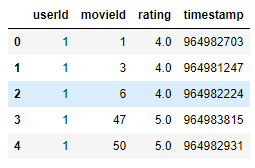

### Transform

**Convert the datetime format**

The int64 format is clearly suitable for userId and movieId. However, we need to dive deeper to understand the timestamps in the data. To use Amazon Personalize, you need to save timestamps in Unix Epoch format. We will use the below python code to transform:

```python
print(arb_time_stamp)
print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

Output::
964982681.0
2000-07-30 18:44:41
```

**Convert explicit to implicit**

Our dataset has an additional column, rating, which can be dropped from the dataset after we have leveraged it to focus on positive interactions. Since this is an explicit feedback movie rating dataset, it includes movies rated from 1 to 5, we want to include only moves that weree "liked" by the users, and simulate a implicit dataset that is more like what data would be gathered by a VOD platform. For that so we will filter out all interactions under 2 out of 5, and create an EVENT_Type of "click" and an EVENT_Type of "watch". We will then assign all movies rated 2 and above as "click" and movies above 4 and above as "click" and "watch".

```python
watched_df = original_data.copy()
watched_df = watched_df[watched_df['rating'] > 3]
watched_df = watched_df[['userId', 'movieId', 'timestamp']]
watched_df['EVENT_TYPE']='watch'

clicked_df = original_data.copy()
clicked_df = clicked_df[clicked_df['rating'] > 1]
clicked_df = clicked_df[['userId', 'movieId', 'timestamp']]
clicked_df['EVENT_TYPE']='click'
```

**Change column names**

Amazon Personalize has default column names for users, items, and timestamp. These default column names are USER_ID, ITEM_ID, AND TIMESTAMP.

```python
interactions_df.rename(columns = {'userId':'USER_ID', 'movieId':'ITEM_ID', 
                              'timestamp':'TIMESTAMP'}, inplace = True)
```

**Create the dataset group**

The highest level of isolation and abstraction with Amazon Personalize is a dataset group. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one - they are completely isolated. The following cell will create a new dataset group with the name `personalize-poc-movielens`.

```python
create_dataset_group_response = personalize.create_dataset_group(name="personalize-poc-movielens")
```

**Create the dataset**

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset.

```python
interactions_schema = schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "personalize-poc-movielens-interactions",
    schema = json.dumps(interactions_schema)
)
```

With a schema created, you can create a dataset within the dataset group.

```python
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-poc-movielens-ints",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)
```

### Load

So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to the instance running this Jupyter notebook. However, Amazon Personalize will need an S3 bucket to act as the source of your data, as well as IAM roles for accessing that bucket. 

```python
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + "personalizepocvod"
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
        )
```

Now that your Amazon S3 bucket has been created, upload the CSV file of our user-item-interaction data.

```python
interactions_file_path = data_dir + "/" + interactions_filename
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+interactions_filename
```

<!---------------------------->

## ETL for Item metadata

Duration: 10

### Extract

Download from official MovieLens source. The head will look like this:

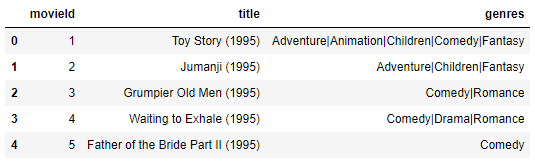

### Transform

**Create the movie release year column**

The title includes the year of the movies release. Let's make that another column of metadata:

```python
original_data['year'] =original_data['title'].str.extract('.*\((.*)\).*',expand = False)
```

**Remove the title column**

From an item metadata perspective, we only want to include information that is relevant to training a model and/or filtering resulte, so we will drop the title, retaining the genre information.

**Changing column names**

Amazon Personalize has a default column for ITEM_ID that will map to our movieId, and now we can flesh out more information by specifying GENRE as well.

```python
itemmetadata_df.rename(columns = {'genres':'GENRE', 'movieId':'ITEM_ID', 'year':'YEAR'}, inplace = True)
```

**Creating the dataset and loading to S3**

```python
itemmetadata_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "GENRE",
            "type": "string",
            "categorical": True
        },{
            "name": "YEAR",
            "type": "int",
        },
        
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "personalize-poc-movielens-item",
    schema = json.dumps(itemmetadata_schema)
)
```

```python
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-poc-movielens-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = itemmetadataschema_arn
)
```

```python
itemmetadata_file_path = data_dir + "/" + itemmetadata_filename
boto3.Session().resource('s3').Bucket(bucket_name).Object(itemmetadata_filename).upload_file(itemmetadata_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+itemmetadata_filename
```

<!---------------------------->

## Import the dataset

Duration: 5

Earlier you created the dataset group and dataset to house your information, so now you will execute an import job that will load the data from the S3 bucket into the Amazon Personalize dataset.

### Import interaction dataset

```python
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "personalize-poc-import1",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)
```

### Import item meta dataset

```python
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "personalize-poc-item-import1",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, itemmetadata_filename)
    },
    roleArn = role_arn
)
```

<!---------------------------->

## Create the solution

Duration: 10

We will build 3 solutons:

1. User Personalization - what items are most relevant to a specific user.
2. Similar Items - given an item, what items are similar to it.
3. Personalized Ranking - given a user and a collection of items, in what order are they most releveant.

### User Personalization

The User-Personalization (aws-user-personalization) recipe is optimized for all USER_PERSONALIZATION recommendation scenarios. When recommending items, it uses automatic item exploration.

With automatic exploration, Amazon Personalize automatically tests different item recommendations, learns from how users interact with these recommended items, and boosts recommendations for items that drive better engagement and conversion. This improves item discovery and engagement when you have a fast-changing catalog, or when new items, such as news articles or promotions, are more relevant to users when fresh.

You can balance how much to explore (where items with less interactions data or relevance are recommended more frequently) against how much to exploit (where recommendations are based on what we know or relevance). Amazon Personalize automatically adjusts future recommendations based on implicit user feedback.

```python
# create the solution
user_personalization_create_solution_response = personalize.create_solution(
    name = "personalize-poc-userpersonalization",
    datasetGroupArn = dataset_group_arn,
    recipeArn = user_personalization_recipe_arn
)
user_personalization_solution_arn = user_personalization_create_solution_response['solutionArn']

# create the solution version
userpersonalization_create_solution_version_response = personalize.create_solution_version(
    solutionArn = user_personalization_solution_arn
)
userpersonalization_solution_version_arn = userpersonalization_create_solution_version_response['solutionVersionArn']
```

### S**IMS**

SIMS is one of the oldest algorithms used within Amazon for recommendation systems. A core use case for it is when you have one item and you want to recommend items that have been interacted with in similar ways over your entire user base. This means the result is not personalized per user. Sometimes this leads to recommending mostly popular items, so there is a hyperparameter that can be tweaked which will reduce the popular items in your results.

For our use case, using the Movielens data, let's assume we pick a particular movie. We can then use SIMS to recommend other movies based on the interaction behavior of the entire user base. The results are not personalized per user, but instead, differ depending on the movie we chose as our input.

```python
# create the solution
sims_create_solution_response = personalize.create_solution(
    name = "personalize-poc-sims",
    datasetGroupArn = dataset_group_arn,
    recipeArn = SIMS_recipe_arn
)
sims_solution_arn = sims_create_solution_response['solutionArn']

# create the solution version
sims_create_solution_version_response = personalize.create_solution_version(
    solutionArn = sims_solution_arn
)
sims_solution_version_arn = sims_create_solution_version_response['solutionVersionArn']
```

### Personalized Ranking

Personalized Ranking is an interesting application of HRNN. Instead of just recommending what is most probable for the user in question, this algorithm takes in a user and a list of items as well. The items are then rendered back in the order of most probable relevance for the user. The use case here is for filtering on unique categories that you do not have item metadata to create a filter, or when you have a broad collection that you would like better ordered for a particular user.

For our use case, using the MovieLens data, we could imagine that a VOD application may want to create a shelf of comic book movies, or movies by a specific director. We most likely have these lists based title metadata we have. We would use personalized ranking to re-order the list of movies for each user, based on their previous tagging history.

```python
# create the solution
rerank_create_solution_response = personalize.create_solution(
    name = "personalize-poc-rerank",
    datasetGroupArn = dataset_group_arn,
    recipeArn = rerank_recipe_arn
)
rerank_solution_arn = rerank_create_solution_response['solutionArn']

# create the solution version
rerank_create_solution_version_response = personalize.create_solution_version(
    solutionArn = rerank_solution_arn
)
rerank_solution_version_arn = rerank_create_solution_version_response['solutionVersionArn']
```

<!---------------------------->

## Hyperparameter tuning

Duration: 5

Personalize offers the option of running hyperparameter tuning when creating a solution. Because of the additional computation required to perform hyperparameter tuning, this feature is turned off by default. Therefore, the solutions we created above, will simply use the default values of the hyperparameters for each recipe. For more information about hyperparameter tuning, see the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/customizing-solution-config-hpo.html).

If you have settled on the correct recipe to use, and are ready to run hyperparameter tuning, the following code shows how you would do so, using SIMS as an example.

```python
sims_create_solution_response = personalize.create_solution(
    name = "personalize-poc-sims-hpo",
    datasetGroupArn = dataset_group_arn,
    recipeArn = SIMS_recipe_arn,
    performHPO=True
)

sims_solution_arn = sims_create_solution_response['solutionArn']
print(json.dumps(sims_create_solution_response, indent=2))
```

If you already know the values you want to use for a specific hyperparameter, you can also set this value when you create the solution. The code below shows how you could set the value for the `popularity_discount_factor` for the SIMS recipe.

```python
sims_create_solution_response = personalize.create_solution(
    name = "personalize-poc-sims-set-hp",
    datasetGroupArn = dataset_group_arn,
    recipeArn = SIMS_recipe_arn,
    solutionConfig = {
        'algorithmHyperParameters': {
            'popularity_discount_factor': '0.7'
        }
    }
)

sims_solution_arn = sims_create_solution_response['solutionArn']
print(json.dumps(sims_create_solution_response, indent=2))
```

<!---------------------------->

## Evaluating solution versions

Duration: 10

Let's take a look at the evaluation metrics for each of the solutions produced.

### Evaluation of User Personalization solution

```python
user_personalization_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = userpersonalization_solution_version_arn
)

print(json.dumps(user_personalization_solution_metrics_response, indent=2))
```

```json
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:136455442858:solution/personalize-poc-userpersonalization/236f000b",
  "metrics": {
    "coverage": 0.0791,
    "mean_reciprocal_rank_at_25": 0.269,
    "normalized_discounted_cumulative_gain_at_10": 0.2687,
    "normalized_discounted_cumulative_gain_at_25": 0.3321,
    "normalized_discounted_cumulative_gain_at_5": 0.2279,
    "precision_at_10": 0.0571,
    "precision_at_25": 0.0379,
    "precision_at_5": 0.075
  },
  "ResponseMetadata": {
    "RequestId": "fa6f0e49-b87d-48ce-ab27-80e61a1ab395",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 17 Sep 2020 00:41:11 GMT",
      "x-amzn-requestid": "fa6f0e49-b87d-48ce-ab27-80e61a1ab395",
      "content-length": "417",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
```

The normalized discounted cumulative gain above tells us that at 5 items, we have less than a (38% for full 22% for small) chance in a recommendation being a part of a user's interaction history (in the hold out phase from training and validation). Around 13% of the recommended items are unique, and we have a precision of only (14% for full, 7.5% for small) in the top 5 recommended items.

This is clearly not a great model, but keep in mind that we had to use rating data for our interactions because Movielens is an explicit dataset based on ratings. The Timestamps also were from the time that the movie was rated, not watched, so the order is not the same as the order a viewer would watch movies.

### Evaluation of SIMS solution

```python
sims_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = sims_solution_version_arn
)

print(json.dumps(sims_solution_metrics_response, indent=2))
```

```json
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:136455442858:solution/personalize-poc-sims/c1a33236",
  "metrics": {
    "coverage": 0.1861,
    "mean_reciprocal_rank_at_25": 0.1669,
    "normalized_discounted_cumulative_gain_at_10": 0.2234,
    "normalized_discounted_cumulative_gain_at_25": 0.2895,
    "normalized_discounted_cumulative_gain_at_5": 0.1889,
    "precision_at_10": 0.0588,
    "precision_at_25": 0.0418,
    "precision_at_5": 0.0824
  },
  "ResponseMetadata": {
    "RequestId": "662598d1-86f0-49a1-98a9-1c3924882f4b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 17 Sep 2020 00:41:11 GMT",
      "x-amzn-requestid": "662598d1-86f0-49a1-98a9-1c3924882f4b",
      "content-length": "404",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
```

In this example we are seeing a slightly elevated precision at 5 items, a little over (4.5% for full, 6.4% for small) this time. Effectively this is probably within the margin of error, but given that no effort was made to mask popularity, it may just be returning super popular results that a large volume of users have interacted with in some way.

### Evaluation of Personalized Ranking solution

```python
rerank_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = rerank_solution_version_arn
)

print(json.dumps(rerank_solution_metrics_response, indent=2))
```

```json
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:136455442858:solution/personalize-poc-rerank/eae37049",
  "metrics": {
    "coverage": 0.0038,
    "mean_reciprocal_rank_at_25": 0.0537,
    "normalized_discounted_cumulative_gain_at_10": 0.0707,
    "normalized_discounted_cumulative_gain_at_25": 0.0956,
    "normalized_discounted_cumulative_gain_at_5": 0.0578,
    "precision_at_10": 0.0132,
    "precision_at_25": 0.0113,
    "precision_at_5": 0.0189
  },
  "ResponseMetadata": {
    "RequestId": "01f86e05-9408-4456-97d3-2548d2cc998e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 17 Sep 2020 00:41:11 GMT",
      "x-amzn-requestid": "01f86e05-9408-4456-97d3-2548d2cc998e",
      "content-length": "406",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
```

Just a quick comment on this one, here we see again a precision of near (2.7% for full, 2.2% for small), as this is based on User Personalization, that is to be expected. However the sample items are not the same for validaiton, thus the low scoring.

<!---------------------------->

## Deploying campaigns

Duration: 5

At this point, you should have several solutions and at least one solution version for each. Once a solution version is created, it is possible to get recommendations from them, and to get a feel for their overall behavior. We will be deploying each of the solution versions into individual campaigns. Once they are active, there are resources for querying the recommendations, and helper functions to digest the output into something more human-readable.

### Deploy User Personalization campaign

```python
userpersonalization_create_campaign_response = personalize.create_campaign(
    name = "personalize-poc-userpersonalization",
    solutionVersionArn = userpersonalization_solution_version_arn,
    minProvisionedTPS = 1
)

userpersonalization_campaign_arn = userpersonalization_create_campaign_response['campaignArn']
```

### Deploy SIMS campaign

```python
sims_create_campaign_response = personalize.create_campaign(
    name = "personalize-poc-SIMS",
    solutionVersionArn = sims_solution_version_arn,
    minProvisionedTPS = 1
)

sims_campaign_arn = sims_create_campaign_response['campaignArn']
```

### Deploy Personalized Ranking campaign

```python
rerank_create_campaign_response = personalize.create_campaign(
    name = "personalize-poc-rerank",
    solutionVersionArn = rerank_solution_version_arn,
    minProvisionedTPS = 1
)

rerank_campaign_arn = rerank_create_campaign_response['campaignArn']
```

<!---------------------------->

## Create filters

Duration: 5

Now that all campaigns are deployed and active, we can create filters. Filters can be created for both Items and Events. A few common use cases for filters in Video On Demand are:

Categorical filters based on Item Metadata - Often your item metadata will have information about thee title such as Genre, Keyword, Year, Decade etc. Filtering on these can provide recommendations within that data, such as action movies.

Events - you may want to filter out certain events and provide results based on those events, such as moving a title from a "suggestions to watch" recommendation to a "watch again" recommendations.

```python
# Create a list for the filters:
meta_filter_arns = []

# Iterate through Genres
for genre in genres_to_filter:
    # Start by creating a filter
    try:
        createfilter_response = personalize.create_filter(
            name=genre,
            datasetGroupArn=dataset_group_arn,
            filterExpression='INCLUDE ItemID WHERE Items.GENRE IN ("'+ genre +'")'
        )
        # Add the ARN to the list
        meta_filter_arns.append(createfilter_response['filterArn'])
        print("Creating: " + createfilter_response['filterArn'])
    
    # If this fails, wait a bit
    except ClientError as error:
        # Here we only care about raising if it isnt the throttling issue
        if error.response['Error']['Code'] != 'LimitExceededException':
            print(error)
        else:    
            time.sleep(120)
            createfilter_response = personalize.create_filter(
                name=genre,
                datasetGroupArn=dataset_group_arn,
                filterExpression='INCLUDE ItemID WHERE Items.GENRE IN ("'+ genre +'")'
            )
            # Add the ARN to the list
            meta_filter_arns.append(createfilter_response['filterArn'])
            print("Creating: " + createfilter_response['filterArn'])
```

Lets also create 2 event filters for watched and unwatched content

```python
createwatchedfilter_response = personalize.create_filter(name='watched',
    datasetGroupArn=dataset_group_arn,
    filterExpression='INCLUDE ItemID WHERE Interactions.event_type IN ("watch")'
    )

createunwatchedfilter_response = personalize.create_filter(name='unwatched',
    datasetGroupArn=dataset_group_arn,
    filterExpression='EXCLUDE ItemID WHERE Interactions.event_type IN ("watch")'
    )

interaction_filter_arns = [createwatchedfilter_response['filterArn'], createunwatchedfilter_response['filterArn']]
```

Finally since we now have the year available in our item metadata, lets create a decade filter to recommend only moviees releaseed in a given decade, for this workshop we will choosee 1970s cinema.

```python
createdecadefilter_response = personalize.create_filter(name='1970s',
    datasetGroupArn=dataset_group_arn,
    filterExpression='INCLUDE ItemID WHERE Items.YEAR >= 1970 AND Items.YEAR < 1980'
    )

decade_filter_arns = [createdecadefilter_response['filterArn']]
```

<!---------------------------->

## Interacting with the campaigns

Duration: 5

SIMS requires just an item as input, and it will return items which users interact with in similar ways to their interaction with the input item. In this particular case the item is a movie.

The cells below will handle getting recommendations from SIMS and rendering the results. Let's see what the recommendations are for the first item we looked at earlier in this notebook (Terminator 2: Judgment Day).

```python
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = sims_campaign_arn,
    itemId = str(589),
)

item_list = get_recommendations_response['itemList']
for item in item_list:
    print(get_movie_by_id(movie_id=item['itemId']))
```

HRNN is one of the more advanced algorithms provided by Amazon Personalize. It supports the personalization of the items for a specific user based on their past behavior and can intake real-time events in order to alter recommendations for a user without retraining.

You can see the recommendations for movies within a given genre. Within a VOD application you could create Shelves (also known as rails or carosels) easily by using these filters. Depending on the information you have about your items, You could also filter on additional information such as keyword, year/decade etc.

```python
recommendations_df_shelves = pd.DataFrame()
for filter_arn in meta_filter_arns:
    recommendations_df_shelves = get_new_recommendations_df_by_filter(recommendations_df_shelves, user, filter_arn)
for filter_arn in decade_filter_arns:
    recommendations_df_shelves = get_new_recommendations_df_by_filter(recommendations_df_shelves, user, filter_arn)

recommendations_df_shelves
```

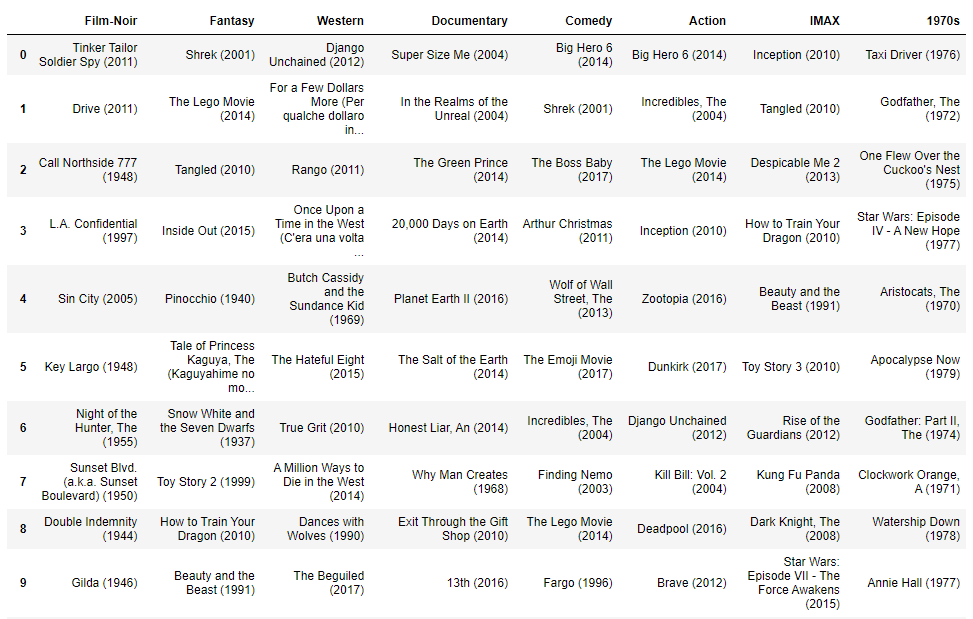

## Cleaning up

Duration: 5

### Clean up campiagns

Start by cleaning up the campaigns. You need to delete campaigns before you can delete the solution versions upon which they are based.

The code below will delete the Campaigns you created.

```python
personalize.delete_campaign(
    campaignArn = userpersonalization_campaign_arn
)
personalize.delete_campaign(
    campaignArn = sims_campaign_arn
)
personalize.delete_campaign(
    campaignArn = rerank_campaign_arn
)
```

### **Clean up event trackers**

Next, clean up any event trackers. The code below will delete your event tracker.

```python
personalize.delete_event_tracker(
    eventTrackerArn = event_tracker_arn
)
```

### **Clean up Filters**

Next, clean up any filters. The code below iterate over all filters you created and delete them. Note, if you get an error about a campaign, that is fine, wait for 2 minutes then try the cell below again.

Note: You will not be able to delete the filters until the campaign deletion completes, which may take a few minutes

```python
**for** filter_arn **in** meta_filter_arns:
    personalize.delete_filter(
        filterArn = filter_arn
    )
**for** filter_arn **in** interaction_filter_arns:
    personalize.delete_filter(
        filterArn = filter_arn
    )
**for** filter_arn **in** decade_filter_arns:
    personalize.delete_filter(
        filterArn = filter_arn
    )
```

### **Clean up solutions**

Next, clean up the solutions. The code below will delete the solutions that were created.

```python
personalize.delete_solution(
    solutionArn = user_personalization_solution_arn
)
personalize.delete_solution(
    solutionArn = sims_solution_arn
)
personalize.delete_solution(
    solutionArn = rerank_solution_arn
)
```

### **Clean up datasets**

Next, clean up the datasets. The code below will delete the item and interactions datasets.

```python
personalize.delete_dataset(
    datasetArn = items_dataset_arn
)
personalize.delete_dataset(
    datasetArn = interactions_dataset_arn
)
```

### **Clean up the schemas**

Next, clean up the schemas. You create an interaction and item schema, delete them.

```python
personalize.delete_schema(
    schemaArn = interaction_schema_arn
)
personalize.delete_schema(
    schemaArn = itemmetadataschema_arn
)
```

### **Clean up the dataset groups**

Finally, clean up the dataset group:

```python
personalize.delete_dataset_group(
    datasetGroupArn = dataset_group_arn
)
```

### **Clean up the S3 bucket and IAM role**

Start by deleting the role, then empty the bucket, then delete the bucket.

```python
iam = boto3.client('iam')
```

Identify the name of the role you want to delete.

You cannot delete an IAM role which still has policies attached to it. So after you have identified the relevant role, let's list the attached policies of that role.

```python
iam.list_attached_role_policies(
    RoleName = role_name
)
```

You need to detach the policies in the result above using the code below. Repeat for each attached policy.

```python
iam.detach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
)
```

```python
iam.detach_role_policy(
    RoleName = role_name,
    PolicyArn = 'arn:aws:iam::aws:policy/AmazonS3FullAccess'
)
```

Finally, you should be able to delete the IAM role.

```python
iam.delete_role(
    RoleName = role_name
)
```

To delete an S3 bucket, it first needs to be empty. The easiest way to delete an S3 bucket, is just to navigate to S3 in the AWS console, delete the objects in the bucket, and then delete the S3 bucket itself.

<!---------------------------->

## Conclusion

Duration: 2

Congratulations!

### What we've covered

1. Setup the environment using CloudFormation template
2. Open the SageMaker Jupyter Lab instance
3. Extract, Transform & Load
4. Train the recommender model and build the campaign
5. Evaluate solution versions
6. Deploy campaigns
7. Create filters
8. Interact with the campaigns
9. Clean the environment by deleting all the resources

### Links and References

1. [https://github.com/aws-samples/amazon-personalize-samples/tree/master/next_steps/workshops/POC_in_a_box](https://github.com/aws-samples/amazon-personalize-samples/tree/master/next_steps/workshops/POC_in_a_box)
2. [https://github.com/apac-ml-tfc/personalize-poc](https://github.com/apac-ml-tfc/personalize-poc)
3. [https://github.com/lmorri/vodpocinabox](https://github.com/lmorri/vodpocinabox)